In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In this notebook, we will explore several types of Regression models on a Medical Cost dataset found on Kaggle( https://www.kaggle.com/mirichoi0218/insurance ) to see if we can predict if certain factors can predict medical costs. This data set shows individual medical costs as billed by insurance. The identity of each individual is hidden but some personal data is given such as: age, sex, BMI, how many children they have, if they are as smoker, and what region they are from. We have no data on the diagnosis of patients. But we have other information that can help us to make a conclusion about the health of patients and practice regression analysis.

Let's Start With Exploratory Data Analysis (EDA)!

In [2]:
#Load data
csv_url = 'https://raw.githubusercontent.com/mkung8889/ML_Regression/master/insurance.csv'
df = pd.read_csv(csv_url)

In [13]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,yes,southwest,16884.92400
1,18,1,33.770,1,no,southeast,1725.55230
2,28,1,33.000,3,no,southeast,4449.46200
3,33,1,22.705,0,no,northwest,21984.47061
4,32,1,28.880,0,no,northwest,3866.85520


In [4]:
#Check for any null values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

There is no NaN values, so no need to use SciKit Imputer to handle missing data in the dataset.

## Let's Start some EDA: 
### Medical Charges:
Let's first take a look at "charges"

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64


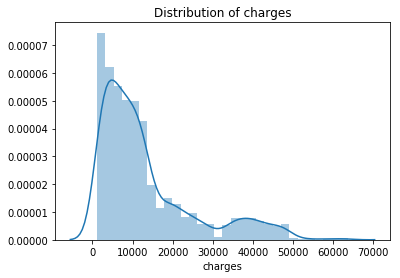

In [5]:
print(df.charges.describe())
sns.distplot(df.charges)
plt.title('Distribution of charges')
plt.show()

We can see there is quite a range of charges, from 1121.8 all the way to 63770.42. It seems a large majority of charges are 16,639.91 or lower.  

Now lets look at correlation between features!

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['sex'] = le.fit_transform(df['sex'])
df['smoker'] = le.fit_transform(df['smoker'])
df['region'] = le.fit_transform(df['region'])

In [15]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [16]:
df.corr()['charges'].sort_values()

region     -0.006208
sex         0.057292
children    0.067998
bmi         0.198341
age         0.299008
smoker      0.787251
charges     1.000000
Name: charges, dtype: float64

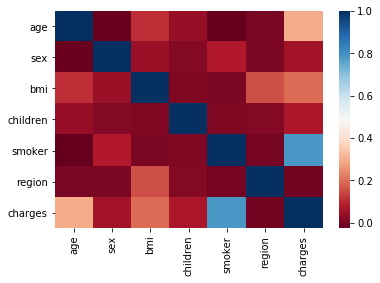

In [17]:
sns.heatmap(df.corr(), cmap='RdBu')

We see there is a strong correlation between 'smoker' and 'charges'. I would have expected bmi to also be highly correlated to charges. 

### Smoker Analysis:

Text(0.5, 1.0, 'Distribution of charges for non-smokers')

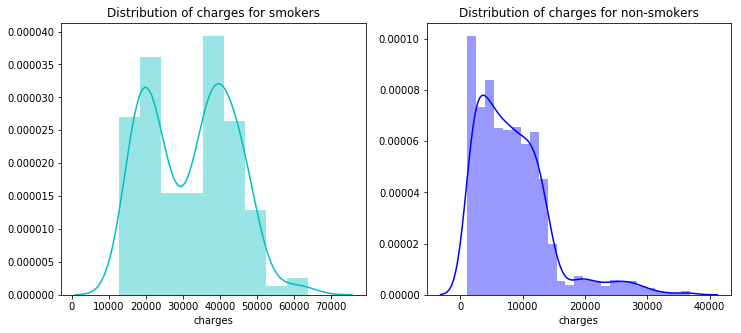

In [18]:
f= plt.figure(figsize=(12,5))

ax1=f.add_subplot(121)
sns.distplot(df[(df.smoker == 1)]["charges"],color='c',ax=ax1)
ax1.set_title('Distribution of charges for smokers')

ax2=f.add_subplot(122)
sns.distplot(df[(df.smoker == 0)]['charges'],color='b',ax=ax2)
ax2.set_title('Distribution of charges for non-smokers')

We can see smokers' charge range much higher than non-smokers. But lets see how many smokers and non-smokers there are.

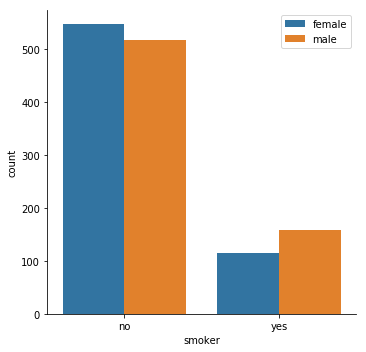

In [19]:
sns.catplot(x='smoker',hue='sex', kind='count', legend=False, data=df)
plt.xticks(np.arange(2), labels=['no', 'yes'])
plt.legend(labels=('female', 'male'))
plt.show()

We can see there are much more non-smokers than smokers. We can also see there are more male smokers than female.

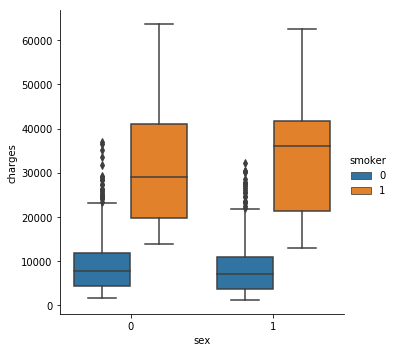

In [20]:
sns.catplot(x="sex", y="charges", hue="smoker", kind="box", data=df)
plt.show()

Here we see that, smokers indeed have the higher charges independent of sex. As expected there are outliers in the non-smoker group who have higher medical charges, possibly due to accidents or serious disease etc. 

Now that we have looked closer at the smoker feature, lets start looking into the other variables.
### Age Analysis:

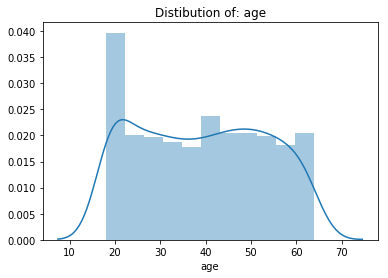

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64
young adult (18-35): 549
senior adult (36-53): 466
elder (54+): 270

age 18: 69
age 19: 68
age 20: 29
age 21: 28


In [21]:
sns.distplot(df.age)
plt.title('Distibution of: age')
plt.show()
print(df.age.describe())
print("""young adult (18-35): {}
senior adult (36-53): {}
elder (54+): {}
""".format(df['age'].loc[(df['age']>=18) & (df['age']<35)].count(), 
           df['age'].loc[(df['age']>=36) & (df['age']<53)].count(), 
           df['age'].loc[(df['age']>=54)].count()
          ))
for i in range(18,22):
    print('age {}:'.format(i), df['age'].loc[df['age']==i].count())

We see the age range is 18 to 64 with a mean age of 39. There are more much more 18 and 19 year olds than any other age. 

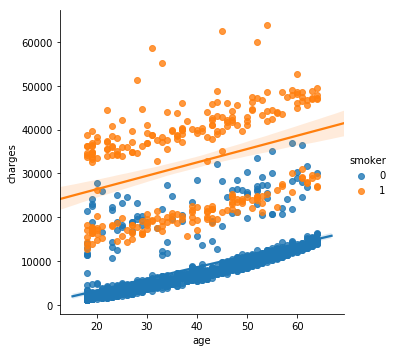

In [22]:
sns.lmplot(x='age', y='charges',hue='smoker', data=df)
plt.show()

In [27]:
# sns.scatterplot(x=df[(df.smoker == 'yes')].age, y=df[(df.smoker == 'yes')].charges, hue='sex', data=df)
# plt.show()

### BMI analysis:

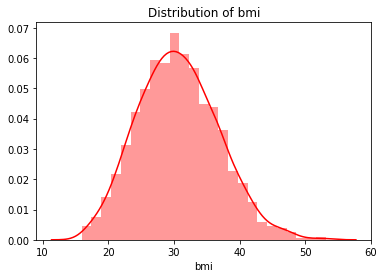

In [28]:
sns.distplot(df.bmi, color='red')
plt.title('Distribution of bmi')
plt.show()

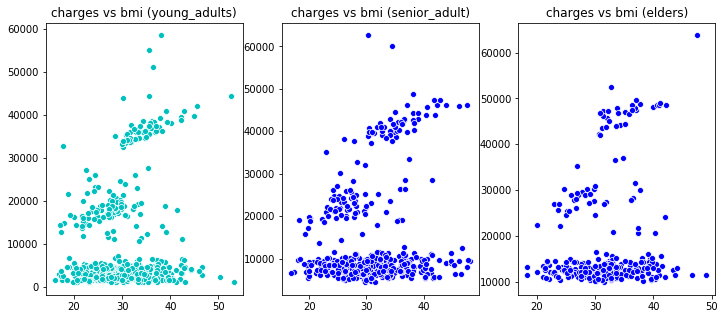

In [29]:
young_adults = df.loc[(df['age']>=18) & (df['age']<35)]
senior_adult = df.loc[(df['age']>=36) & (df['age']<53)]
elders = df.loc[(df['age']>=54)]

f= plt.figure(figsize=(12,5))

ax1=f.add_subplot(131)
sns.scatterplot(x=young_adults['bmi'].values, y=young_adults['charges'].values,color='c',ax=ax1)
ax1.set_title('charges vs bmi (young_adults)')

ax2=f.add_subplot(132)
sns.scatterplot(x=senior_adult['bmi'].values, y=senior_adult['charges'].values,color='b',ax=ax2)
ax2.set_title('charges vs bmi (senior_adult)')

ax3=f.add_subplot(133)
sns.scatterplot(x=elders['bmi'].values, y=elders['charges'].values,color='b',ax=ax3)
ax3.set_title('charges vs bmi (elders)')
plt.show()

In [30]:
young_adults = df.loc[(df['age']>=18) & (df['age']<35)]

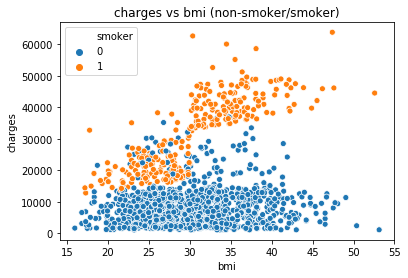

In [31]:
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df)
plt.title('charges vs bmi (non-smoker/smoker)')
plt.show()

Through our analysis, we see BMI has a almost perfect normal disctribution. There is no difference in charges related to bmi between young-adults, senior-adults, and elders. 

According to the American Cancer Society (https://www.cancer.org/cancer/cancer-causes/diet-physical-activity/body-weight-and-cancer-risk/adult-bmi.html):
- Underweight: BMI is less than 18.5
- Normal weight: BMI is 18.5 to 24.9
- Overweight: BMI is 25 to 29.9
- Obese: BMI is 30 or more

We also see that smokers who are obese (BMI>=30) spend much more treatment than smokers who are not obese (BMI<30).

### Number of Children + Region Analysis:
Lastly, let's look at the number of children patients have and region patients are in.

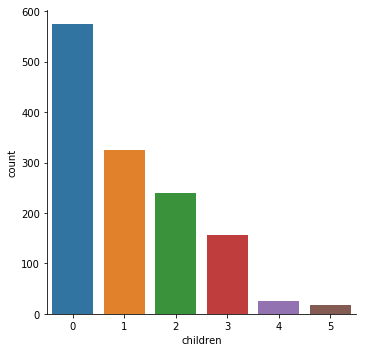

In [32]:
sns.catplot(x='children', kind='count', data=df)
plt.show()

The are much more patients who do not have children, which is expected because there are much more 18 and 19 year olds patients in this dataset than any other age.

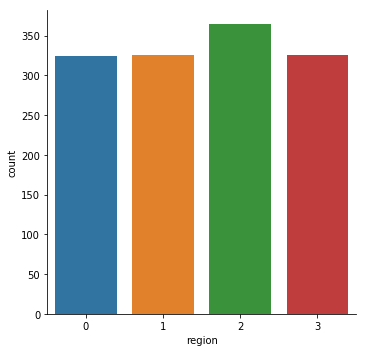

In [33]:
sns.catplot(x='region', kind='count', data=df)
plt.show()

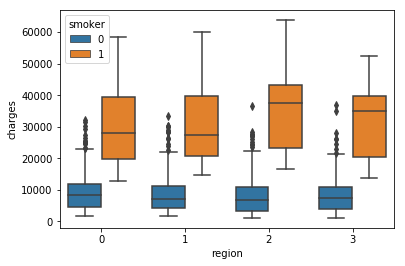

In [34]:
sns.boxplot(x='region', y='charges',hue='smoker', data=df)
plt.show()

There is no real difference between regions and the number of patients from each region is about the same.

## Let's Start Modeling!

We are going to look at multiple different regression models:
- Multiple Linear Regression
- Polynomial Linear Regression
- Decision Tree Regression
- Random Forest Regresssion

### First, Preprocessing!


Let's first set our X and y variables

In [35]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [ ]:
X = df.iloc[:,:-1].values
y = df['charges'].values

In [ ]:
print(X[:5])
print(y[:5])

We need to use LabelEncoder for all the categorical features ('sex', 'smoker', 'region') and use OneHotEncoder for the 'region' feature.

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le_X = LabelEncoder()
X[:, 1] = le_X.fit_transform(X[:,1])
X[:, 4] = le_X.fit_transform(X[:,4])
X[:, 5] = le_X.fit_transform(X[:,5])
ohe = OneHotEncoder(categorical_features=[5])
X = ohe.fit_transform(X).toarray()
X = X[:,1:]

In [ ]:
print(X[:5])

In [ ]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X[:,[3,5,6]] = sc_X.fit_transform(X[:,[3,5,6]])
y = sc_y.fit_transform(y.reshape(-1, 1))

In [ ]:
#Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

### Multiple Linear Regression

In [ ]:
# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
multilr = LinearRegression()
multilr.fit(X_train, y_train)

# Predicting the Test set results
multilr_pred = multilr.predict(X_test)
multilr_pred_train = multilr.predict(X_train)

multilr_score = multilr.score(X_test, y_test)
multilr_score_train = multilr.score(X_train, y_train)
print("""Multiple Linear Regression R2 Score: 
train: {}
test: {}""".format(multilr_score_train, multilr_score))

In [ ]:
plt.scatter(multilr_pred_train, multilr_pred_train-y_train, color='gray', label='Training Data')
plt.scatter(multilr_pred, multilr_pred-y_test, color='red', label='Test Data')
plt.hlines(y=0, xmin=multilr_pred.min(), xmax=multilr_pred.max())
plt.legend()
plt.show()

### Polynomial Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
#poly = PolynomialFeatures(degree=2)
#poly = PolynomialFeatures(degree=3)
#poly = PolynomialFeatures(degree=4)
#poly = PolynomialFeatures(degree=5)
poly = PolynomialFeatures(degree=6)
X_poly = poly.fit_transform(X)
X_test_poly = poly.fit_transform(X_test)
X_train_poly = poly.fit_transform(X_train)
polylr = LinearRegression()
polylr.fit(X_poly, y)
poly_pred = polylr.predict(X_test_poly)
poly_pred_train = polylr.predict(X_train_poly)

polylr_score = polylr.score(X_test_poly, y_test)
polylr_score_train = polylr.score(X_train_poly, y_train)
print("""Polynomial Linear Regression R2 Score: 
train: {}
test: {}""".format(polylr_score_train, polylr_score))

In [ ]:
plt.scatter(poly_pred_train, poly_pred_train-y_train, color='gray', label='Training Data')
plt.scatter(poly_pred, poly_pred-y_test, color='red', label='Test Data')
plt.hlines(y=0, xmin=poly_pred.min(), xmax=poly_pred.max())
plt.legend()
plt.show()

### Support Vector Regression (SVR):

In [ ]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf')
svr.fit(X, y)
svr_pred = svr.predict(X_test)
svr_pred_train = svr.predict(X_train)
svr_score = svr.score(X_test, y_test)
svr_score_train = svr.score(X_train, y_train)
print("""Multiple Linear Regression R2 Score: 
train: {}
test: {}""".format(svr_score_train, svr_score))

In [ ]:
plt.scatter(svr_pred_train.reshape(-1,1), svr_pred_train.reshape(-1,1)-y_train, color='gray', label='Training Data')
plt.scatter(svr_pred.reshape(-1,1), svr_pred.reshape(-1,1)-y_test, color='red', label='Test Data')
plt.hlines(y=0, xmin=svr_pred.min(), xmax=svr_pred.max())
plt.legend()
plt.show()

### Decision Tree:

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X,y)
dtr_pred = dtr.predict(X_test)
dtr_pred_train = dtr.predict(X_train)
dtr_score = dtr.score(X_test, y_test)
dtr_score_train = dtr.score(X_train, y_train)
print("""Multiple Linear Regression R2 Score: 
train: {}
test: {}""".format(dtr_score_train, dtr_score))

In [ ]:
plt.scatter(dtr_pred_train.reshape(-1,1), dtr_pred_train.reshape(-1,1)-y_train, color='gray', label='Training Data')
plt.scatter(dtr_pred.reshape(-1,1), dtr_pred.reshape(-1,1)-y_test, color='red', label='Test Data')
plt.hlines(y=0, xmin=dtr_pred.min(), xmax=dtr_pred.max())
plt.legend()
plt.show()

In [ ]:
# plt.scatter(sc_y.inverse_transform(dtr_pred_train), sc_y.inverse_transform(dtr_pred_train.reshape(-1,1))-sc_y.inverse_transform(y_train), color='gray', label='Training Data')
plt.scatter(sc_y.inverse_transform(dtr_pred), sc_y.inverse_transform(dtr_pred.reshape(-1,1))-sc_y.inverse_transform(y_test), color='red', label='Test Data')
plt.hlines(y=0, xmin=sc_y.inverse_transform(dtr_pred.reshape(-1,1)).min(), xmax=sc_y.inverse_transform(dtr_pred.reshape(-1,1)).max())
plt.legend()
plt.show()

In [ ]:
plt.scatter(sc_y.inverse_transform(dtr_pred), 
            sc_y.inverse_transform(dtr_pred.reshape(-1,1)) - sc_y.inverse_transform(y_test),
            c = 'c', marker = 'o', s = 35, alpha = 0.7,
            label = 'Test data')
plt.title('Decision Tree Regression')
plt.xlabel('Predicted values')
plt.ylabel('Tailings')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')
plt.show()

### Random Forest Regression:

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=10,
                            criterion='mse')
rfr.fit(X,y)
rfr_pred = rfr.predict(X_test)
rfr_pred_train = rfr.predict(X_train)
rfr_score = rfr.score(X_test, y_test)
rfr_score_train = rfr.score(X_train, y_train)
print("""Multiple Linear Regression R2 Score: 
train: {}
test: {}""".format(rfr_score_train, rfr_score))

In [ ]:
plt.scatter(rfr_pred_train.reshape(-1,1), rfr_pred_train.reshape(-1,1)-y_train, color='gray', label='Training Data')
plt.scatter(rfr_pred.reshape(-1,1), rfr_pred.reshape(-1,1) - y_test, color='red', label='Test Data')
plt.hlines(y=0, xmin=rfr_pred.min(), xmax=rfr_pred.max())
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
multilf_mse = mean_squared_error(y_test, multilr_pred)
multilf_mse_train = mean_squared_error(y_train, multilr_pred_train)

polylr_mse = mean_squared_error(y_test, poly_pred)
polylr_mse_train = mean_squared_error(y_train, poly_pred_train)

svr_mse = mean_squared_error(y_test, svr_pred)
svr_mse_train = mean_squared_error(y_train, svr_pred_train)

dtr_mse = mean_squared_error(y_test, dtr_pred)
dtr_mse_train = mean_squared_error(y_train, dtr_pred_train)

rfr_mse = mean_squared_error(y_test, rfr_pred)
rfr_mse_train = mean_squared_error(y_train, rfr_pred_train)

print("""Multivariate Linear Regression:
Polynomial Linear Regression: 
train: {}
test: {}

Support Vector Regression: 
train: {}
test: {}

Decision Tree Regression: 
train: {}
test: {}

Random Forest Regression: 
train: {}
test: {}
""".format(multilf_mse_train, multilf_mse, 
           polylr_mse_train, polylr_mse, 
           svr_mse_train, svr_mse,
           dtr_mse_train, dtr_mse,
           rfr_mse_train, rfr_mse))

In [ ]:
results_df = pd.DataFrame({
    'Regression': ['Multivariate Linear',
                  'Polynomial Linear',
                  'Support Vector',
                  'Decision Tree',
                  'Random Forest'],
    'R2_Score_train': [multilr_score_train,
                polylr_score_train,
                svr_score_train,
                dtr_score_train,
                rfr_score_train],
    'R2_Score_test': [multilr_score,
                polylr_score,
                svr_score,
                dtr_score,
                rfr_score],
    'MSE_train': [multilf_mse_train, 
             polylr_mse_train, 
             svr_mse_train, 
             dtr_mse_train, 
             rfr_mse_train],
    'MSE_test': [multilf_mse, 
         polylr_mse, 
         svr_mse, 
         dtr_mse, 
         rfr_mse]
})
results_df.round(decimals=6)

WOW! Decision Tree Regression is an awesome regression model for this data!